In [1]:
import json, os, pandas, pathlib, peft, torch, transformers

from torch.utils.data import Dataset, DataLoader
from lightning import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_float32_matmul_precision('high')

base_model_name = "gpt2-medium"
data_path = "data/board-game.jsonl"

Fire we define a reusable helper function to ask a response from a LLM model based on a prompt using a tokenizer.

In [2]:
def get_response(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)
    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        top_p=0.8,
        top_k=50,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id,
    )
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    return text[len(prompt):].lstrip()

In [3]:
base_model = AutoModelForCausalLM.from_pretrained(base_model_name, dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token
print("Loaded a pretrained model of type", type(base_model))

Loaded a pretrained model of type <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


# Base model prompting
After having loaded the base model we ask a prompt that it will probably not do well on. In this case it produces a lot of non-sense and addresses our prompt to explain board game characteristics rather poorly.

In [4]:
prompt = "Explain some typical characteristics of a board game."
response = get_response(base_model, tokenizer, prompt)
print(response)

"The rules are laid out in the style and order that they're intended to be played, with no extraneous bits or extra cards added." — Joe Lantz, designer of Magic: The Gathering (1996).




# Load the data set
Here we load the data set with the text about board games. The text is stored in sets of `prompt` and `completion` elements, where the idea is that the model learns what kind of responses are correct for what kind of prompts. By default LLMs return the given prompt as the start of the response. Given that we wish to train some Q&A type model, the question text should not be used for loss calculations (repeating the question does not make the answer better or worse). To this end we indicate the prompt text as irrelevant for loss calculation by marking its tokens with `-100`.

In [5]:
class JsonlDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len=256):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        with pathlib.Path(file_path).open() as f:
            for line in f:
                obj = json.loads(line)
                self.samples.append((obj["prompt"], obj["completion"]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        prompt, completion = self.samples[idx]
        tokenized = self.tokenizer(prompt + completion, truncation=True, max_length=self.max_len)
        input_ids = torch.tensor(tokenized["input_ids"])
        attention_mask = torch.tensor(tokenized["attention_mask"])
        labels = input_ids.clone()
        prompt_len = len(self.tokenizer(prompt, add_special_tokens=False)["input_ids"])
        labels[:prompt_len] = -100 # For every prompt token set the label to -100, so it is not used in loss calculation.
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}
  
dataset = JsonlDataset(data_path, tokenizer)
print("Created a dataset with", len(dataset), "samples")

Created a dataset with 593 samples


# Data Loaders
We define two data loaders, one for training and one for validation. This example notebook does not involve a testing phase, so training and validation are all we need here. The collate function ensures that all items in a batch are of equal length by padding them with pad tokens. Additionally, for each pad token it sets the attention mask to 0 and its label to -100 (meaning irrelevant).

In [6]:
def collate(batch):
    input_ids = [b["input_ids"] for b in batch]
    attention_mask = [b["attention_mask"] for b in batch]
    labels = [b["labels"] for b in batch]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

class TextDataModule(LightningDataModule):    
    def __init__(self, data, split=[.8, .2], batch_size=4, num_workers=0):
        super().__init__()
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        torch.manual_seed(42)
        self.train, self.val = torch.utils.data.random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, collate_fn=collate, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val, collate_fn=collate, batch_size=self.batch_size, num_workers=self.num_workers)

datamodule = TextDataModule(dataset)

In [7]:

class LoRA(LightningModule):
    def __init__(self, base_model, learning_rate=5e-5, weight_decay=0.01, warmup_steps=200):
        super().__init__()
        self.save_hyperparameters(ignore=["base_model"])
        model = peft.prepare_model_for_kbit_training(base_model)
        lora_cfg = peft.LoraConfig(
            r=32,
            lora_alpha=64,
            target_modules=["c_attn", "c_proj"],  # For GPT‑style models
            lora_dropout=0.05,
            bias="none",
            fan_in_fan_out=True,
        )
        self.model = peft.get_peft_model(model, lora_cfg)

    def forward(self, **batch):
        return self.model(**batch)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        return outputs.loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        val_loss = outputs.loss
        self.log("val_loss", val_loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
        scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=self.trainer.estimated_stepping_batches)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

lora = LoRA(base_model)

In [8]:
logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_loss", mode="min", patience=3)
trainer = Trainer(max_epochs=-1, logger=logger, callbacks=[stop], accumulate_grad_batches=4)
trainer.fit(lora, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode  | FLOPs
----------------------------------------------------
0 | model | PeftModel | 363 M  | train | 0    
----------------------------------------------------
8.7 M     Trainable params
354 M     Non-trainable params
363 M     Total params
1,453.896 Total estimated model params size (MB)
722       Modules in train mode
320       Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:534: Found 320 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If th

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

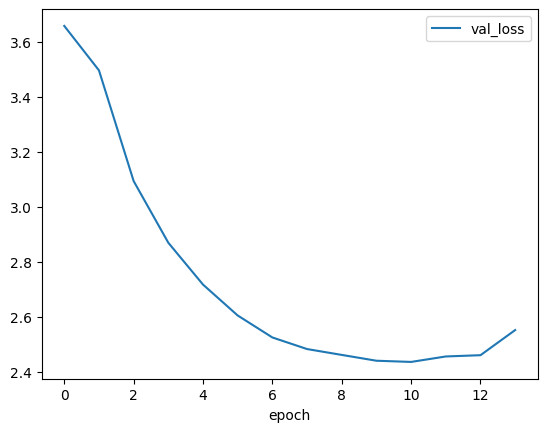

In [9]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

In [10]:
prompt = "Explain some typical characteristics of a board game."
response = get_response(lora.model, tokenizer, prompt)
print(response)

Aboardgame is interactive, involving multiple players interacting with the boards through strategic placement and interaction in the environment — creating immersive experiences through carefully designed interactions between players or pieces.The tabletop format creates engaging gameplay, requiring participants to act independently but maintaining balance by balancing resources and player choices within the board game context.[1]Board games include complex systems that require efficient planning, negotiation skills (eXplosive), resource management,[2][3], mechanical precision ("the art of positioning"), and tactical decision
